In [1]:
import matplotlib 
matplotlib.use('Pdf')

import numpy as np
from pylab import *


caffe_root = '/home/ubuntu/workspace/caffe/'  # this file should be run from {caffe_root}/examples (otherwise change this line)

import sys
sys.path.insert(0, caffe_root + 'python')
import caffe
import random

caffe.set_device(0)
caffe.set_mode_gpu()


%matplotlib inline
import tempfile




In [2]:
import os
os.chdir(caffe_root)  # run scripts from caffe root
!data/ilsvrc12/get_ilsvrc_aux.sh
!scripts/download_model_binary.py models/bvlc_reference_caffenet
!python examples/finetune_flickr_style/assemble_data.py \
    --workers=-1  --seed=1701 \
    --images=$NUM_STYLE_IMAGES  --label=$NUM_STYLE_LABELS
# back to examples
os.chdir('../master_project')

Downloading...
--2016-07-10 15:53:39--  http://dl.caffe.berkeleyvision.org/caffe_ilsvrc12.tar.gz
Resolving dl.caffe.berkeleyvision.org (dl.caffe.berkeleyvision.org)... 169.229.222.251
Connecting to dl.caffe.berkeleyvision.org (dl.caffe.berkeleyvision.org)|169.229.222.251|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 17858008 (17M) [application/octet-stream]
Saving to: 'caffe_ilsvrc12.tar.gz'

100%[======================================>] 17,858,008  7.41MB/s   in 2.3s   

2016-07-10 15:53:41 (7.41 MB/s) - 'caffe_ilsvrc12.tar.gz' saved [17858008/17858008]

Unzipping...
Done.
Model already exists.

(process:13598): Gtk-WARNING **: Locale not supported by C library.
	Using the fallback 'C' locale.
error: XDG_RUNTIME_DIR not set in the environment.
error: XDG_RUNTIME_DIR not set in the environment.

(assemble_data.py:13598): Gdk-CRITICAL **: gdk_cursor_new_for_display: assertion 'GDK_IS_DISPLAY (display)' failed
Traceback (most recent call last):
  File "examples

In [3]:
import os
weights = caffe_root + 'models/bvlc_reference_caffenet/bvlc_reference_caffenet.caffemodel'
assert os.path.exists(weights)

caffe_model_prototxt = caffe_root + 'models/bvlc_reference_caffenet/deploy.prototxt'
caffe_model_trained = caffe_root + 'models/bvlc_reference_caffenet/bvlc_reference_caffenet.caffemodel'
dateset_path = '/home/ubuntu/data/stanford_mobile_images/'

# Model Definition
## Caffe Model
It is a caffe model called CaffeNet (based on AlexNet) there have to be some sort of it on disk.

In [4]:
from caffe import layers as L
from caffe import params as P

weight_param = dict(lr_mult=1, decay_mult=1)
bias_param   = dict(lr_mult=2, decay_mult=0)
learned_param = [weight_param, bias_param]

frozen_param = [dict(lr_mult=0)] * 2


def conv_relu(bottom, ks, nout, stride=1, pad=0, group=1,
              param=learned_param,
              weight_filler=dict(type='gaussian', std=0.01),
              bias_filler=dict(type='constant', value=0.1)):
    conv = L.Convolution(bottom, kernel_size=ks, stride=stride,
                         num_output=nout, pad=pad, group=group,
                         param=param, weight_filler=weight_filler,
                         bias_filler=bias_filler)
    return conv, L.ReLU(conv, in_place=True)

def fc_relu(bottom, nout, param=learned_param,
            weight_filler=dict(type='gaussian', std=0.005),
            bias_filler=dict(type='constant', value=0.1)):
    fc = L.InnerProduct(bottom, num_output=nout, param=param,
                        weight_filler=weight_filler,
                        bias_filler=bias_filler)
    return fc, L.ReLU(fc, in_place=True)

def max_pool(bottom, ks, stride=1):
    return L.Pooling(bottom, pool=P.Pooling.MAX, kernel_size=ks, stride=stride)

def caffenet(data, label=None, train=True, num_classes=1000,
             classifier_name='fc8', learn_all=False):
    """Returns a NetSpec specifying CaffeNet, following the original proto text
       specification (./models/bvlc_reference_caffenet/train_val.prototxt)."""
    n = caffe.NetSpec()
    n.data = data
    param = learned_param if learn_all else frozen_param
    n.conv1, n.relu1 = conv_relu(n.data, 11, 96, stride=4, param=param)
    n.pool1 = max_pool(n.relu1, 3, stride=2)
    n.norm1 = L.LRN(n.pool1, local_size=5, alpha=1e-4, beta=0.75)
    n.conv2, n.relu2 = conv_relu(n.norm1, 5, 256, pad=2, group=2, param=param)
    n.pool2 = max_pool(n.relu2, 3, stride=2)
    n.norm2 = L.LRN(n.pool2, local_size=5, alpha=1e-4, beta=0.75)
    n.conv3, n.relu3 = conv_relu(n.norm2, 3, 384, pad=1, param=param)
    n.conv4, n.relu4 = conv_relu(n.relu3, 3, 384, pad=1, group=2, param=param)
    n.conv5, n.relu5 = conv_relu(n.relu4, 3, 256, pad=1, group=2, param=param)
    n.pool5 = max_pool(n.relu5, 3, stride=2)
    n.fc6, n.relu6 = fc_relu(n.pool5, 4096, param=param)
    if train:
        n.drop6 = fc7input = L.Dropout(n.relu6, in_place=True)
    else:
        fc7input = n.relu6
    n.fc7, n.relu7 = fc_relu(fc7input, 4096, param=param)
    if train:
        n.drop7 = fc8input = L.Dropout(n.relu7, in_place=True)
    else:
        fc8input = n.relu7
    # always learn fc8 (param=learned_param)
    fc8 = L.InnerProduct(fc8input, num_output=num_classes, param=learned_param)
    # give fc8 the name specified by argument `classifier_name`
    n.__setattr__(classifier_name, fc8)
    if not train:
        n.probs = L.Softmax(fc8)
    if label is not None:
        n.label = label
        n.loss = L.SoftmaxWithLoss(fc8, n.label)
        n.acc = L.Accuracy(fc8, n.label)
    # write the net to a temporary file and return its filename
    with tempfile.NamedTemporaryFile(delete=False) as f:
        f.write(str(n.to_proto()))
        print 'model file name: ', f.name
        return f.name

### Creating model network
At this stage: 
    1. we are creating a dummy data that is fit to our input layer. 
    2. calling our caffenet function, that creates a file with our networks architecture in it. 
    3. using the file, create a network.

In [5]:
dummy_data = L.DummyData(shape=dict(dim=[1, 3, 227, 227]))
imagenet_net_filename = caffenet(data=dummy_data, train=False)
imagenet_net = caffe.Net(imagenet_net_filename, weights, caffe.TEST)

model file name:  /tmp/tmpbPSkMS


## My Model

In [6]:
import os

def file_formatter(folder):
    """
    This function prepare files for caffe input.
    It gets folder name, and creates a text file with list of images in the given folder.
    And returns text file name.
    """
    counter = 0
    ts = 0.5
    if folder.split('/')[-1] == 'Reference':
        with open(folder + '/images.txt', 'w') as output:
            top = '/home/ubuntu/data/cd_covers/'
            for f in os.listdir(top):
                if f == 'Reference': 
                    for ff in os.listdir(top + f):
                        if os.path.isfile(top + f + '/' + ff) and ff.endswith('.jpg'):
                            output.write('{0}/{1} {1}\n'.format(top + f,  ff))
                            #in the format of: /path/to/file/0xx.jpg 0xx.jpg(class)
                            counter += 1
                else:
                    for ff in os.listdir(top + f):
                        if os.path.isfile(top + f + '/' + ff) and ff.endswith('.jpg'):
                            if random.random() > ts:
                                output.write('{0}/{1} {1}\n'.format(top + f,  ff))
                            #in the format of: /path/to/file/0xx.jpg 0xx.jpg(class)
                            #counter += 1
    else:
        with open(folder + '/images.txt', 'w') as output:
            for f in os.listdir(folder):
                if os.path.isfile(folder + '/' + f) and f.endswith('.jpg'):
                    
                    output.write('{0}/{1} {1}\n'.format(folder, f))
                    #in the format of: /path/to/file/0xx.jpg 0xx.jpg(class)
                    counter += 1
    return '{0}/{1}'.format(folder, 'images.txt'), counter

In [7]:
source, class_number = file_formatter('/home/ubuntu/data/cd_covers/Reference')
class_number

100

In [8]:
def payam_net(train=True, learn_all=False, subset=None):
    batch_size = 20
    if subset is None:
        subset = 'train' if train else 'test'
    #source = caffe_root + 'data/flickr_style/%s.txt' % subset
    if subset == 'train':
        folder = '/home/ubuntu/data/cd_covers/Reference'
    else:
        folder = '/home/ubuntu/data/cd_covers/Canon'
    source, class_number = file_formatter(folder)
    
    transform_param = dict(mirror=train, crop_size=227,
        mean_file=caffe_root + 'data/ilsvrc12/imagenet_mean.binaryproto')
    mobile_data, mobile_label = L.ImageData(
        transform_param=transform_param, source=source,
        batch_size=batch_size, new_height=256, new_width=256, ntop=2)
    return caffenet(data=mobile_data, label=mobile_label, train=train,
                    num_classes=class_number,
                    classifier_name='fc8_mobile',
                    learn_all=learn_all)

### Create my model

In [9]:


untrained_net = caffe.Net(payam_net(train=False, subset='train'),
                                weights, caffe.TEST)
untrained_net.forward()
data_batch = untrained_net.blobs['data'].data.copy()
label_batch = np.array(untrained_net.blobs['label'].data, dtype=np.int32)
print label_batch

model file name:  /tmp/tmpJigvAf
[19 44 12 40 46 58 27 11 10  5 51 78 69 66 84 60 64 94  7 56]


In [10]:
def disp_preds(net, image, labels, k=5, name='ImageNet'):
    input_blob = net.blobs['data']
    net.blobs['data'].data[0, ...] = image
    probs = net.forward(start='conv1')['probs'][0]
    top_k = (-probs).argsort()[:k]
    print 'top %d predicted %s labels =' % (k, name)
    print '\n'.join('\t(%d) %5.2f%% %s' % (i+1, 100*probs[p], labels[p])
                    for i, p in enumerate(top_k))

def disp_imagenet_preds(net, image):
    disp_preds(net, image, imagenet_labels, name='ImageNet')

def disp_style_preds(net, image):
    disp_preds(net, image, labels, name='style')
def deprocess_net_image(image):
    image = image.copy()              # don't modify destructively
    image = image[::-1]               # BGR -> RGB
    image = image.transpose(1, 2, 0)  # CHW -> HWC
    image += [123, 117, 104]          # (approximately) undo mean subtraction

    # clamp values in [0, 255]
    image[image < 0], image[image > 255] = 0, 255

    # round and cast from float32 to uint8
    image = np.round(image)
    image = np.require(image, dtype=np.uint8)

    return image

actual label = 005.jpg


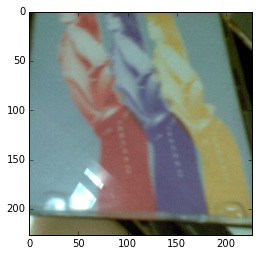

In [11]:
batch_index = 9
labels = []
for i in range(class_number):
    labels.append(str(i).zfill(3) + '.jpg')
image = data_batch[batch_index]
plt.imshow(deprocess_net_image(image))
print 'actual label =', labels[label_batch[batch_index]]

In [12]:
# Load ImageNet labels to imagenet_labels
imagenet_label_file = caffe_root + 'data/ilsvrc12/synset_words.txt'
imagenet_labels = list(np.loadtxt(imagenet_label_file, str, delimiter='\t'))
assert len(imagenet_labels) == 1000
print 'Loaded ImageNet labels:\n', '\n'.join(imagenet_labels[:10] + ['...'])

Loaded ImageNet labels:
n01440764 tench, Tinca tinca
n01443537 goldfish, Carassius auratus
n01484850 great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias
n01491361 tiger shark, Galeocerdo cuvieri
n01494475 hammerhead, hammerhead shark
n01496331 electric ray, crampfish, numbfish, torpedo
n01498041 stingray
n01514668 cock
n01514859 hen
n01518878 ostrich, Struthio camelus
...


In [13]:
disp_imagenet_preds(imagenet_net, image)

top 5 predicted ImageNet labels =
	(1) 23.02% n02786058 Band Aid
	(2) 15.67% n07615774 ice lolly, lolly, lollipop, popsicle
	(3)  8.09% n03871628 packet
	(4)  3.83% n04116512 rubber eraser, rubber, pencil eraser
	(5)  3.13% n03729826 matchstick


In [14]:
del untrained_net

In [15]:
from caffe.proto import caffe_pb2

def solver(train_net_path, test_net_path=None, base_lr=0.001):
    print '0'
    s = caffe_pb2.SolverParameter()
    print '1'
    # Specify locations of the train and (maybe) test networks.
    s.train_net = train_net_path
    if test_net_path is not None:
        s.test_net.append(test_net_path)
        s.test_interval = 1000  # Test after every 1000 training iterations.
        s.test_iter.append(100) # Test on 100 batches each time we test.

    # The number of iterations over which to average the gradient.
    # Effectively boosts the training batch size by the given factor, without
    # affecting memory utilization.
    s.iter_size = 1
    
    s.max_iter = 100000     # # of times to update the net (training iterations)
    print '2'
    # Solve using the stochastic gradient descent (SGD) algorithm.
    # Other choices include 'Adam' and 'RMSProp'.
    s.type = 'SGD'

    # Set the initial learning rate for SGD.
    s.base_lr = base_lr

    # Set `lr_policy` to define how the learning rate changes during training.
    # Here, we 'step' the learning rate by multiplying it by a factor `gamma`
    # every `stepsize` iterations.
    s.lr_policy = 'step'
    s.gamma = 0.1
    s.stepsize = 20000

    # Set other SGD hyperparameters. Setting a non-zero `momentum` takes a
    # weighted average of the current gradient and previous gradients to make
    # learning more stable. L2 weight decay regularizes learning, to help prevent
    # the model from overfitting.
    s.momentum = 0.9
    s.weight_decay = 5e-4
    print '3'
    # Display the current training loss and accuracy every 1000 iterations.
    s.display = 1000

    # Snapshots are files used to store networks we've trained.  Here, we'll
    # snapshot every 10K iterations -- ten times during training.
    s.snapshot = 10000
    s.snapshot_prefix = caffe_root + 'models/finetune_flickr_style/finetune_flickr_style'
    
    # Train on the GPU.  Using the CPU to train large networks is very slow.
    s.solver_mode = caffe_pb2.SolverParameter.CPU
    print '4'
    # Write the solver to a temporary file and return its filename.
    with tempfile.NamedTemporaryFile(delete=False) as f:
        f.write(str(s))
        print f.name
        return f.name

In [16]:
def run_solvers(niter, solvers, disp_interval=10):
    """Run solvers for niter iterations,
       returning the loss and accuracy recorded each iteration.
       `solvers` is a list of (name, solver) tuples."""
    blobs = ('loss', 'acc')
    loss, acc = ({name: np.zeros(niter) for name, _ in solvers}
                 for _ in blobs)
    for it in range(niter):
        for name, s in solvers:
            s.step(1)  # run a single SGD step in Caffe
            loss[name][it], acc[name][it] = (s.net.blobs[b].data.copy()
                                             for b in blobs)
        if it % disp_interval == 0 or it + 1 == niter:
            loss_disp = '; '.join('%s: loss=%.3f, acc=%2d%%' %
                                  (n, loss[n][it], np.round(100*acc[n][it]))
                                  for n, _ in solvers)
            print '%3d) %s' % (it, loss_disp)     
    # Save the learned weights from both nets.
    weight_dir = tempfile.mkdtemp()
    weights = {}
    for name, s in solvers:
        filename = 'weights.%s.caffemodel' % name
        weights[name] = os.path.join(weight_dir, filename)
        s.net.save(weights[name])
    return loss, acc, weights

In [17]:
niter = 200  # number of iterations to train

# Reset style_solver as before.
solver_filename = solver(payam_net(train=True))
mobile_solver = caffe.get_solver(solver_filename)
mobile_solver.net.copy_from(weights)

print 'here'
# For reference, we also create a solver that isn't initialized from
# the pretrained ImageNet weights.
scratch_solver_filename = solver(payam_net(train=True))
scratch_solver = caffe.get_solver(scratch_solver_filename)

print 'Running solvers for %d iterations...' % niter
solvers = [('pretrained', mobile_solver),
           ('scratch', scratch_solver)]
loss, acc, weights = run_solvers(niter, solvers)
print 'Done.'

train_loss, scratch_train_loss = loss['pretrained'], loss['scratch']
train_acc, scratch_train_acc = acc['pretrained'], acc['scratch']
weights, scratch_weights = weights['pretrained'], weights['scratch']

# Delete solvers to save memory.
del mobile_solver, scratch_solver, solvers

model file name:  /tmp/tmpxzVtIj
0
1
2
3
4
/tmp/tmpdYoQBB
here
model file name:  /tmp/tmpEf723v
0
1
2
3
4
/tmp/tmp5mMaGl
Running solvers for 200 iterations...
  0) pretrained: loss=4.605, acc= 0%; scratch: loss=4.605, acc= 5%
 10) pretrained: loss=4.615, acc= 0%; scratch: loss=4.606, acc= 0%
 20) pretrained: loss=3.197, acc=55%; scratch: loss=4.593, acc= 0%
 30) pretrained: loss=2.220, acc=80%; scratch: loss=4.586, acc=10%
 40) pretrained: loss=1.740, acc=95%; scratch: loss=4.596, acc= 0%
 50) pretrained: loss=1.226, acc=90%; scratch: loss=4.573, acc= 5%
 60) pretrained: loss=0.849, acc=100%; scratch: loss=4.579, acc= 0%
 70) pretrained: loss=0.508, acc=100%; scratch: loss=4.631, acc= 0%
 80) pretrained: loss=0.521, acc=100%; scratch: loss=4.563, acc= 0%
 90) pretrained: loss=0.701, acc=100%; scratch: loss=4.547, acc= 0%
100) pretrained: loss=0.307, acc=100%; scratch: loss=4.647, acc= 0%
110) pretrained: loss=0.302, acc=100%; scratch: loss=4.544, acc= 0%
120) pretrained: loss=0.352, ac

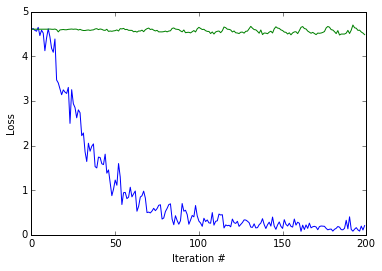

In [18]:
plot(np.vstack([train_loss, scratch_train_loss]).T)
xlabel('Iteration #')
ylabel('Loss')

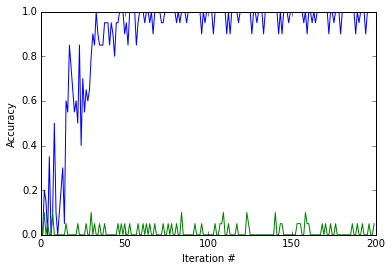

In [19]:
plot(np.vstack([train_acc, scratch_train_acc]).T)
xlabel('Iteration #')
ylabel('Accuracy')

In [20]:
def eval_style_net(weights, test_iters=10):
    test_net = caffe.Net(payam_net(train=False), weights, caffe.TEST)
    accuracy = 0
    for it in xrange(test_iters):
        accuracy += test_net.forward()['acc']
    accuracy /= test_iters
    return test_net, accuracy

In [21]:
test_net, accuracy = eval_style_net(weights)
print 'Accuracy, trained from ImageNet initialization: %3.1f%%' % (100*accuracy, )
scratch_test_net, scratch_accuracy = eval_style_net(scratch_weights)
print 'Accuracy, trained from   random initialization: %3.1f%%' % (100*scratch_accuracy, )

model file name:  /tmp/tmpC4PCWJ
Accuracy, trained from ImageNet initialization: 73.0%
model file name:  /tmp/tmpT_TqL_
Accuracy, trained from   random initialization: 1.0%


In [22]:
end_to_end_net = payam_net(train=True, learn_all=True)

# Set base_lr to 1e-3, the same as last time when learning only the classifier.
# You may want to play around with different values of this or other
# optimization parameters when fine-tuning.  For example, if learning diverges
# (e.g., the loss gets very large or goes to infinity/NaN), you should try
# decreasing base_lr (e.g., to 1e-4, then 1e-5, etc., until you find a value
# for which learning does not diverge).
base_lr = 0.001

solver_filename = solver(end_to_end_net, base_lr=base_lr)
mobile_solver = caffe.get_solver(solver_filename)
mobile_solver.net.copy_from(weights)

scratch_solver_filename = solver(end_to_end_net, base_lr=base_lr)
scratch_solver = caffe.get_solver(scratch_solver_filename)
scratch_solver.net.copy_from(scratch_weights)

print 'Running solvers for %d iterations...' % niter
solvers = [('pretrained, end-to-end', mobile_solver),
           ('scratch, end-to-end', scratch_solver)]
_, _, finetuned_weights = run_solvers(niter, solvers)
print 'Done.'

weights_ft = finetuned_weights['pretrained, end-to-end']
scratch_weights_ft = finetuned_weights['scratch, end-to-end']

# Delete solvers to save memory.
del mobile_solver, scratch_solver, solvers

model file name:  /tmp/tmpJDu5hB
0
1
2
3
4
/tmp/tmpfOVJaD
0
1
2
3
4
/tmp/tmpljFrsO
Running solvers for 200 iterations...
  0) pretrained, end-to-end: loss=1.182, acc=70%; scratch, end-to-end: loss=4.671, acc= 5%
 10) pretrained, end-to-end: loss=0.131, acc=100%; scratch, end-to-end: loss=4.616, acc= 0%
 20) pretrained, end-to-end: loss=0.228, acc=100%; scratch, end-to-end: loss=4.643, acc= 0%
 30) pretrained, end-to-end: loss=0.153, acc=95%; scratch, end-to-end: loss=4.603, acc= 5%
 40) pretrained, end-to-end: loss=0.260, acc=85%; scratch, end-to-end: loss=4.625, acc= 0%
 50) pretrained, end-to-end: loss=0.123, acc=95%; scratch, end-to-end: loss=4.562, acc= 0%
 60) pretrained, end-to-end: loss=0.308, acc=85%; scratch, end-to-end: loss=4.561, acc= 0%
 70) pretrained, end-to-end: loss=0.009, acc=100%; scratch, end-to-end: loss=4.641, acc= 5%
 80) pretrained, end-to-end: loss=0.520, acc=80%; scratch, end-to-end: loss=4.556, acc= 0%
 90) pretrained, end-to-end: loss=2.394, acc=75%; scratch

In [30]:
test_net, accuracy = eval_style_net(weights_ft)
print 'Accuracy, finetuned from ImageNet initialization: %3.1f%%' % (100*accuracy, )
scratch_test_net, scratch_accuracy = eval_style_net(scratch_weights_ft)
print 'Accuracy, finetuned from   random initialization: %3.1f%%' % (100*scratch_accuracy, )

model file name:  /tmp/tmp0jSaIf
Accuracy, finetuned from ImageNet initialization: 8.0%
model file name:  /tmp/tmpYFGhe7
Accuracy, finetuned from   random initialization: 1.0%


actual label = 005.jpg


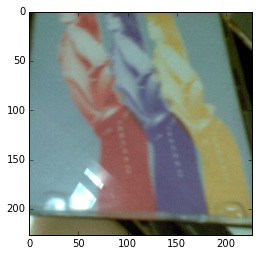

In [24]:

labels = []
for i in range(class_number):
    labels.append(str(i).zfill(3) + '.jpg')

plt.imshow(deprocess_net_image(image))
print 'actual label =', labels[label_batch[batch_index]]

top 5 predicted style labels =
	(1) 29.76% 021.jpg
	(2) 24.29% 005.jpg
	(3) 15.55% 090.jpg
	(4)  6.83% 010.jpg
	(5)  5.01% 007.jpg


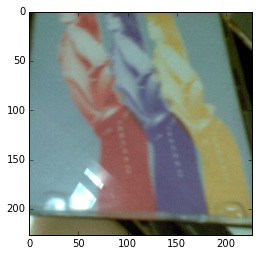

In [25]:
batch_index = 9
image = data_batch[batch_index]
plt.imshow(deprocess_net_image(image))
disp_style_preds(test_net, image)

actual label = 033.jpg


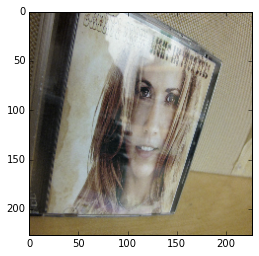

In [26]:
batch_index = 9
image = test_net.blobs['data'].data[batch_index]
plt.imshow(deprocess_net_image(image))
print 'actual label =', labels[int(test_net.blobs['label'].data[batch_index])]

In [27]:
disp_style_preds(test_net, image)

top 5 predicted style labels =
	(1)  5.22% 079.jpg
	(2)  4.65% 021.jpg
	(3)  4.54% 090.jpg
	(4)  4.12% 035.jpg
	(5)  2.55% 074.jpg


In [28]:
disp_style_preds(scratch_test_net, image)

top 5 predicted style labels =
	(1)  1.56% 038.jpg
	(2)  1.47% 074.jpg
	(3)  1.46% 037.jpg
	(4)  1.38% 064.jpg
	(5)  1.34% 007.jpg


In [29]:
disp_imagenet_preds(imagenet_net, image)

top 5 predicted ImageNet labels =
	(1) 11.46% n04209133 shower cap
	(2)  8.09% n04584207 wig
	(3)  4.20% n01484850 great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias
	(4)  4.20% n03908714 pencil sharpener
	(5)  4.00% n03788365 mosquito net
